In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Read the data
langs = ['en','cs','de']
# steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
steps_epoch_mapping = {5: 500, 10: 1000, 15: 1500, 20: 2000, 25: 2500, 30: 3000, 35: 3500, 40: 4000}
kind = ['noisevignere3', 'noiseconstenigma']
evaldatasets = {lang:f'final_eval_dataset_{lang}.csv'  for lang in langs}
vignere_losses = {lang:f'{lang}_vignere_loss.csv'  for lang in langs}
enigmas = {lang:f'{lang}_enigma_loss.csv'  for lang in langs}
eval_col='eval_loss'

def vignerecol_name(lang, epoch):
    return f'{lang}_noisevignere3_{steps_epoch_mapping[epoch]}_cer'

def enigmacol_name(lang, epoch):
    return f'{lang}_noiseconstenigma_{steps_epoch_mapping[epoch]}_cer'


In [2]:
from torchmetrics.text import CharErrorRate
import torch
from tqdm import tqdm

# this is the reference solution
def calculate_cer(row, metric, col1, col2):
    metric.reset()
    # Convert the strings to tensors of unicode code points
    pred, target = row[col1], row[col2]
    # Compute the CER for the current row
    cer = metric(pred, target)
    return cer.item()

def add_cer_column(df, col1, col2, new_col_name):
    # Initialize the CharErrorRate metric
    metric = CharErrorRate()

    # Apply the calculate_cer function to each row
    # axis=1 specifies that the function should be applied row-wise
    tqdm.pandas(desc="Computing CER")

    df[new_col_name] = df.progress_apply(calculate_cer, metric=metric, col1=col1, col2=col2, axis=1)


def make_cer_cols(dfs):
    for df in dfs:
        gen_cols = [col for col in df.columns if 'generated_text' in col]
        # For each error column, create a new column for cer
        for col in gen_cols:
            new_col_name = col.replace('generated_text', 'cer')
            add_cer_column(df, col, 'text', new_col_name)

# solution if we have precomputed levensthein distances from the generated text and the target text
def calculate_my_cer(row,  col1, col2):
    text = row[col2]
    error_count = row[col1]
    return error_count / len(text)


def add_my_cer_column(df, col1, col2, new_col_name):
    # Apply the calculate_cer function to each row
    # axis=1 specifies that the function should be applied row-wise
    tqdm.pandas(desc="Computing CER")

    df[new_col_name] = df.progress_apply(calculate_my_cer,  col1=col1, col2=col2, axis=1)


def make_my_cer_cols(dfs):
    for df in dfs:
        gen_cols = [col for col in df.columns if 'error_count' in col]
        # For each error column, create a new column for cer
        for col in gen_cols:
            new_col_name = col.replace('error_count', 'cer')
            add_my_cer_column(df, col, 'text', new_col_name)

In [3]:
loss_paths = {'en': 'en_vignere_loss.csv', 'cs': 'cs_vignere_loss.csv', 'de': 'de_vignere_loss.csv'}
eval_data_paths = {'en': 'final_eval_dataset_en.csv', 'cs': 'final_eval_dataset_cs.csv', 'de': 'final_eval_dataset_de.csv'}
loss_col = 'eval_loss'
data_dfs= [pd.read_csv(file) for file in eval_data_paths.values()]


In [4]:
# make_my_cer_cols(data_dfs)


In [5]:

from itertools import count
from matplotlib import colors
from seaborn import kdeplot
from scipy.stats import gaussian_kde

# Function to calculate the KDE for a dataset
def calculate_kde(data):
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 500)
    kde_values = kde(x_range)
    return x_range, kde_values


def render(loss_paths, loss_col, langs, vignere_or_enigma='vignere', save=None):
    # print(data)
    losses = [pd.read_csv(file)[loss_col] for file in loss_paths.values()]
    colors = ['blue', 'green', 'red']

    fig, ax1 = plt.subplots(figsize=(6,4.3))
    ax1.set_xlim(0, 41)
    ax1.set_ylim(0,1.5)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    for i, series in enumerate(losses):
        ax1.plot(series, label=langs[i], color=colors[i])  # Plot each series with a label
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Character Error Rate')

    for lang in langs:
        for epoch in steps_epoch_mapping.keys():
            # we want to take the CER from the eval dataset of the corresponding language, for the correct cipher and epoch
            # epoch 4 corresponds to step 500, epoch 9 corresponds to step 1000, etc.
            # columns are named col_name
            if vignere_or_enigma == 'vignere':
                cer_col_name = vignerecol_name(lang, epoch)
            else:
                cer_col_name = enigmacol_name(lang, epoch)
            ser_col = data_dfs[langs.index(lang)][cer_col_name]
            x_range, kdevalues = calculate_kde(ser_col)
            kdevalues_scaled = kdevalues / max(kdevalues) * .6  #consider if too wide
            ax2.fill_betweenx(x_range, epoch - kdevalues_scaled, epoch + kdevalues_scaled,
                              alpha=0.55,
                            #   color='red'
                            color=colors[langs.index(lang)]
                            )

    plot_name = 'Vigenère' if vignere_or_enigma == 'vignere' else 'Enigma'
    plt.title(f'{plot_name} Loss and checkpoint CER density')
    # legend to the bottom left
    ax1.legend(loc='lower left')
    
    # Set both axes to start at 0
    if save:
        plt.savefig(save)
    
    plt.show()
    

    

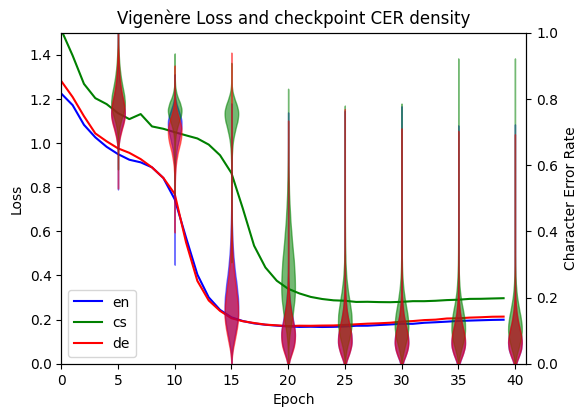

In [6]:

loss_paths = {'en': 'en_vignere_loss.csv', 'cs': 'cs_vignere_loss.csv', 'de': 'de_vignere_loss.csv'}
render(vignere_losses,  eval_col, langs,
        save='../img/vignere_eval_loss.pdf'
        )

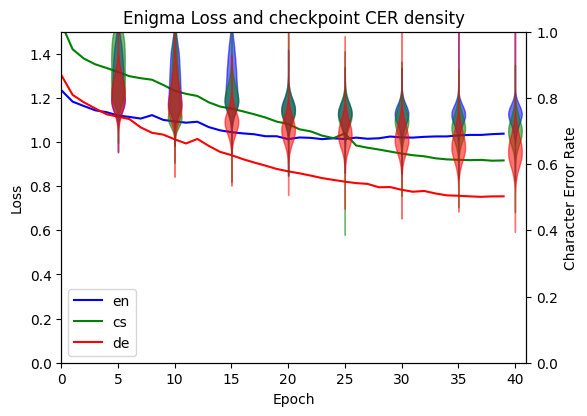

In [7]:
loss_paths = {'en': 'en_enigma_loss.csv', 'cs': 'cs_enigma_loss.csv', 'de': 'de_enigma_loss.csv'}
render(enigmas, eval_col, langs, vignere_or_enigma='enigma',save='../img/enigma_eval_loss.pdf')